In [1]:
import os
import warnings
import string
import pandas as pd
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.testing.evaluation import Evaluation
evaluation = Evaluation(config_path='configs/evaluation/synthetic_distributions.json', name='synthetic') # use this line if you want to run this notbook manually
# evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2DF3-382D-B5F3
Expires at: 2019-08-30 00:00:00


In [3]:
from synthesized.testing import UtilityTesting

In [4]:
from synthesized import HighDimSynthesizer

In [5]:
import numpy as np

In [ ]:
def create_ball(x_mean, x_std, y_mean, y_std, size, cor=0.):
    mean = [x_mean, y_mean]
    cov = [[x_std**2, x_std*y_std*cor], [x_std*y_std*cor, y_std**2]]
    x, y = np.random.multivariate_normal(mean, cov, size).T
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [ ]:
def create_line(x_range, intercept, slope, y_std, size):
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=size)
    y = intercept + x*slope + np.random.normal(loc=0, scale=y_std, size=size)
    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [ ]:
from scipy.stats import powerlaw
def create_power_law_distribution(a, scale, size):
    return pd.DataFrame({'x': scale*powerlaw.rvs(a, size=size)})

In [ ]:
from scipy.stats import bernoulli
def create_bernoulli_distribution(ratio, size):
    df = pd.DataFrame({'x': bernoulli.rvs(ratio, size=size)})
    df['x'] = df['x'].astype('category')
    return df

In [ ]:
def create_conditional_distribution(*norm_params, size):
    df = pd.DataFrame()
    for i, (mean, std) in enumerate(norm_params):
        x = [i] * size
        y = np.random.normal(mean, std, size)
        df = df.append(pd.DataFrame({'x': x, 'y': y}), ignore_index=True)
    df = df.sample(frac=1).reset_index(drop=True)
    df['x'] = df['x'].astype('category')
    return df

In [ ]:
def create_uniform_categorical(n_classes, size):
    df = pd.DataFrame({'x': range(n_classes)})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df

In [ ]:
def create_power_law_categorical(n_classes, size):
    sample = [j for i in range(n_classes) for j in [i]*2**(n_classes-i-1)]
    df = pd.DataFrame({'x': sample})
    df = df.sample(10000, replace=True)
    df['x'] = df['x'].astype('category')
    return df

In [6]:
def create_mixed_continuous_categorical(n_classes, prior_mean=0, prior_sd=5, sd=1, size=10000):
    means = prior_mean + prior_sd*np.random.randn(n_classes)
    categories = np.array([f"v_{i}" for i in list(range(n_classes))])
    discrete = np.random.choice(list(range(n_classes)), size=size)
    zs = np.random.randn(size)
    sample_means = means[discrete]
    values = categories[discrete]
    continuous = sample_means + sd*zs
    return pd.DataFrame({"x": values, "y": continuous})

In [7]:
def create_correlated_categorical(n_classes, size, sd=1.):
    logits = sd*np.random.randn(n_classes*n_classes).reshape(n_classes, n_classes)
    categories = np.array([f"v_{i}" for i in list(range(n_classes))])
    independent = np.random.choice(list(range(n_classes)), size=size)
    gumbels = -np.log(-np.log(np.random.uniform(size=n_classes*size))).reshape(size, n_classes)
    dependent =  (logits[independent] + gumbels).argmax(1)
    independent_values = categories[independent]
    dependent_values = categories[dependent]
    return pd.DataFrame({"x": independent_values, "y": dependent_values}).astype(str)
    
    

In [8]:
def plot_data(data, ax=None):
    if data.shape[1] == 1:
        if data['x'].dtype.kind == 'O':
            return sns.distplot(data, ax=ax, kde=False)
        else:
            return sns.distplot(data, ax=ax)
    if data.shape[1] == 2:
        if data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'f':
            order = sorted(data["x"].unique().tolist())
            sns.violinplot(x="x", y="y", data=data, ax=ax)
        elif data['x'].dtype.kind == 'f' and data['y'].dtype.kind == 'f':
            #return sns.jointplot(x="x", y="y", data=data, kind="kde", ax=ax)
            return ax.hist2d(data['x'], data['y'], bins=100)
        elif data['x'].dtype.kind == 'O' and data['y'].dtype.kind == 'O':
            crosstab = pd.crosstab(data['x'], columns=[data['y']]).apply(lambda r: r/r.sum(), axis=1)
            sns.heatmap(crosstab, vmin=0.0, vmax=1.0, ax=ax)
        else:
            return sns.distplot(data, ax=ax)
    else:
        return sns.distplot(data, ax=ax)

###  Evaluation metrics

In [9]:
def max_correlation_distance(orig, synth):
    return np.abs((orig.corr() - synth.corr()).to_numpy()).max()

def mean_ks_distance(orig, synth):
    distances = [ks_2samp(orig[col], synth[col])[0] for col in orig.columns]
    return np.mean(distances)

In [10]:
import time
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt



default_metrics = {"avg_distance": mean_ks_distance}

def synthesize_and_plot(data, name, n_iter=evaluation.config['num_iterations'], metrics=None, 
                        show_anova=False, show_cat_rsquared=False):
    start = time.time()
    with HighDimSynthesizer(df=data, **evaluation.config['params']) as synthesizer:
        synthesizer.learn(df_train=data, num_iterations=n_iter)
        synthesized = synthesizer.synthesize(num_rows=len(data))
        print('took', time.time() - start, 's')
        for key, metric in metrics.items():
            evaluation[key] = metric(orig=data, synth=synthesized)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('orig')
        ax2.set_title('synth')
        plot_data(data, ax=ax1)
        plot_data(synthesized, ax=ax2)
        if show_anova:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_anova()
        if show_cat_rsquared:
            testing = UtilityTesting(synthesizer, data, data, synthesized)
            testing.show_categorical_rsquared()

### Gauss "ball" outside of center

In [ ]:
data = create_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'ball', metrics=default_metrics)

### Gauss "ball" around of zero

In [ ]:
data = create_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'ball_ext', metrics=default_metrics)

### Correlated Gaussian far from zero

In [ ]:
data = create_ball(x_mean=1000, x_std=100, y_mean=100, y_std=10, size=10000, cor=0.8, eps=1e-6)

In [ ]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_far', metrics=metrics)

### Correlated Gaussian around zero

In [ ]:
data = create_ball(x_mean=0, x_std=100, y_mean=0, y_std=10, size=10000, cor=0.8, eps=1e-6)

In [ ]:
metrics = dict(default_metrics)
metrics["max_correlation_distance"] = max_correlation_distance
synthesize_and_plot(data, 'corr_ball_zero', metrics=metrics)

### Line of noise that far from zero

In [ ]:
data = create_line(x_range=(0, 1000), intercept=100, slope=-0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line', metrics=default_metrics)

### Line of noise that comes from zero

In [ ]:
data = create_line(x_range=(0, 1000), intercept=0, slope=0.1, y_std=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'line_ext', metrics=default_metrics)

### Power law distribution

In [ ]:
data = create_power_law_distribution(a=0.5, scale=1000, size=10000)

In [ ]:
synthesize_and_plot(data, 'power_law', metrics=default_metrics)

### Conditional distribution

In [ ]:
data = create_conditional_distribution((10,2), (20, 5), (30, 1), size=10000)

In [ ]:
synthesize_and_plot(data, 'conditional', metrics=default_metrics)

### Bernoulli distribution

In [ ]:
data = create_bernoulli_distribution(ratio=0.5, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_50/50', metrics=default_metrics)

In [ ]:
data = create_bernoulli_distribution(ratio=0.2, size=10000)

In [ ]:
synthesize_and_plot(data, 'bernoulli_20/80', metrics=default_metrics)

### Categorical distribution

In [ ]:
data = create_uniform_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'categorical_uniform', metrics=default_metrics)

In [ ]:
data = create_power_law_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'categorical_powerlaw', metrics=default_metrics)

In [ ]:
data = create_mixed_continuous_categorical(n_classes=10, size=10000)

In [ ]:
synthesize_and_plot(data, 'mixed_categorical_continuous', metrics=default_metrics, show_anova=True)

In [11]:
data = create_correlated_categorical(n_classes=10, size=10000, sd=1.)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
took 50.645122051239014 s
         Current function value: 1.876096
         Iterations: 35
         Function evaluations: 108
         Gradient evaluations: 108


/Users/amandlamabona/anaconda3/envs/synth_p37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.134452
         Iterations: 35
         Function evaluations: 106
         Gradient evaluations: 106


/Users/amandlamabona/anaconda3/envs/synth_p37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


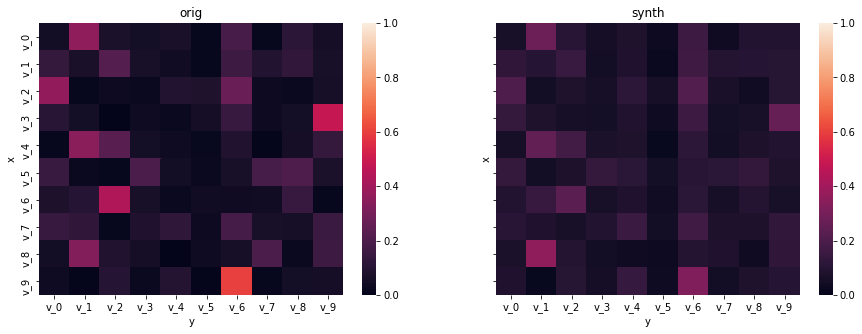

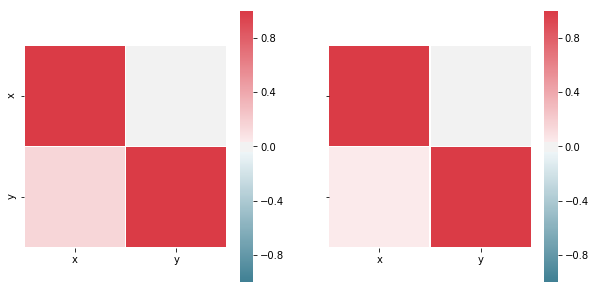

In [12]:
synthesize_and_plot(data, 'correlated_categoricals', metrics=default_metrics, show_cat_rsquared=True)

In [ ]:
evaluation.write_metrics()